In [1]:
import os
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import transforms, datasets
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.feature_selection import SelectKBest, f_classif
from tqdm import tqdm

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [3]:
import torch.nn as nn
import torch.nn.functional as F

class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, 3, 1)
        self.conv2 = nn.Conv2d(32, 64, 3, 1)
        self.conv3 = nn.Conv2d(64, 128, 3, 1)
        self.pool = nn.MaxPool2d(2, 2)
        self.fc1 = nn.Linear(128 * 62 * 62, 512)  # Adjusted input size based on the target image size
        self.fc2 = nn.Linear(512, 10)  # Assuming 10 classes for classification

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = self.pool(F.relu(self.conv3(x)))
        x = x.view(-1, 128 * 62 * 62)  # Adjusted view size based on the target image size
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

In [4]:
# Load data
train_folder = "D:/Projet_Data/dataset"
transform = transforms.Compose([
    transforms.Resize((512, 512)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
])
train_data = datasets.ImageFolder(root=train_folder, transform=transform)
train_loader = DataLoader(train_data, batch_size=9, shuffle=True, drop_last=True)

# Initialize model, loss, and optimizer
model = CNN().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [ ]:
# Custom loss function to handle mismatched batch sizes
def custom_loss(outputs, labels):
    # Calculate loss only on valid elements
    valid_outputs = outputs[:labels.size(0)]
    loss = criterion(valid_outputs, labels)
    return loss

# Train the model
model.train()
total_loss = 0.0
total_samples = 0

for epoch in range(10):
    for images, labels in tqdm(train_loader, desc=f'Epoch {epoch + 1}/{10}', unit='batch'):
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        
        # Calculate loss using custom loss function
        loss = custom_loss(outputs, labels)
        loss.backward()
        optimizer.step()
        
        total_loss += loss.item() * images.size(0)
        total_samples += images.size(0)
    
    print(f"Epoch {epoch + 1}/{10}, Average Loss: {total_loss / total_samples}")

Epoch 1/10:   3%|▎         | 5/185 [00:54<29:27,  9.82s/batch]

In [11]:
# Extract features using the trained model
model.eval()
features = []
labels_list = []
with torch.no_grad():
    for images, labels in tqdm(train_loader, desc='Extracting features', unit='batch'):
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        features.append(outputs.cpu().numpy())
        labels_list.append(labels.cpu().numpy())

features = np.concatenate(features)
class_labels = np.concatenate(labels_list)

# Use SelectKBest to select top 20 features
selector = SelectKBest(score_func=f_classif, k=10)
selected_features = selector.fit_transform(features, class_labels)

# Concatenate selected features with class labels
selected_features_with_labels = np.column_stack((selected_features, class_labels))

# Convert to DataFrame
df = pd.DataFrame(selected_features_with_labels, columns=[f'feature_{i}' for i in range(10)] + ['class'])

# Save DataFrame to CSV
df.to_csv('D:/selected_features.csv', index=False)

Extracting features: 100%|██████████| 122/122 [01:00<00:00,  2.03batch/s]


In [1]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from xgboost import XGBClassifier
import pandas as pd

In [2]:
data = pd.read_csv("D:/selected_features.csv")

In [3]:
data.head()

,feature_0,feature_1,feature_2,feature_3,feature_4,feature_5,feature_6,feature_7,feature_8,feature_9,class
0,2.303434,-2.543594,5.374623,-13.543136,-12.664968,-13.578069,-13.153636,-13.348340,-13.132883,-13.214392,2.0
1,-3.292030,9.315825,-2.325448,-8.224202,-8.700274,-9.162355,-8.065923,-8.535978,-7.813761,-8.288749,1.0
2,6.482268,-0.025002,0.284040,-12.436822,-11.347025,-12.214023,-12.164912,-12.203093,-11.637467,-11.916353,0.0
3,-1.813296,14.699196,-4.693735,-15.119954,-14.501548,-14.645652,-13.171749,-14.868083,-12.924651,-13.337236,1.0
4,-0.525389,-0.437856,8.197629,-10.146022,-12.727314,-11.933422,-11.127310,-12.252780,-13.060232,-12.360912,2.0


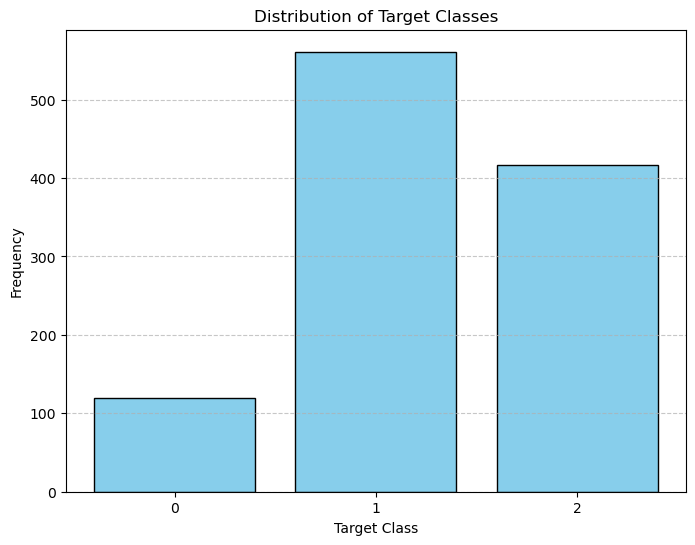

In [5]:
import matplotlib.pyplot as plt

# Assuming you have already imported pandas as pd and read your CSV file into a DataFrame
data = pd.read_csv("D:/selected_features.csv")

# Plotting the target classes
plt.figure(figsize=(8, 6))
plt.hist(data['class'], bins=[0, 1, 2, 3], align='left', rwidth=0.8, color='skyblue', edgecolor='black')
plt.title('Distribution of Target Classes')
plt.xlabel('Target Class')
plt.ylabel('Frequency')
plt.xticks([0, 1, 2])
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

In [6]:
X=data.drop(['class'],axis=1)
y=data[['class']]

In [7]:
# Assuming 'X' contains your features and 'y' contains your target variable
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [8]:

# Train XGBoost model
xgb_model = XGBClassifier()
xgb_model.fit(X_train, y_train)
xgb_pred = xgb_model.predict(X_test)
print("XGBoost Accuracy:", accuracy_score(y_test, xgb_pred))
print("XGBoost Classification Report:")
print(classification_report(y_test, xgb_pred))



XGBoost Accuracy: 0.9863636363636363
XGBoost Classification Report:
              precision    recall  f1-score   support

         0.0       1.00      0.93      0.96        28
         1.0       0.99      1.00      1.00       105
         2.0       0.98      0.99      0.98        87

    accuracy                           0.99       220
   macro avg       0.99      0.97      0.98       220
weighted avg       0.99      0.99      0.99       220



In [9]:
# Train SVM model
svm_model = SVC()
svm_model.fit(X_train, y_train)
svm_pred = svm_model.predict(X_test)
print("SVM Accuracy:", accuracy_score(y_test, svm_pred))
print("SVM Classification Report:")
print(classification_report(y_test, svm_pred))



SVM Accuracy: 0.990909090909091
SVM Classification Report:
              precision    recall  f1-score   support

         0.0       1.00      0.96      0.98        28
         1.0       0.99      1.00      1.00       105
         2.0       0.99      0.99      0.99        87

    accuracy                           0.99       220
   macro avg       0.99      0.98      0.99       220
weighted avg       0.99      0.99      0.99       220



D:\anaconda3\Lib\site-packages\sklearn\utils\validation.py:1184: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [10]:
# Train Decision Tree model
dt_model = DecisionTreeClassifier()
dt_model.fit(X_train, y_train)
dt_pred = dt_model.predict(X_test)
print("Decision Tree Accuracy:", accuracy_score(y_test, dt_pred))
print("Decision Tree Classification Report:")
print(classification_report(y_test, dt_pred))

Decision Tree Accuracy: 0.9863636363636363
Decision Tree Classification Report:
              precision    recall  f1-score   support

         0.0       1.00      0.93      0.96        28
         1.0       0.99      1.00      1.00       105
         2.0       0.98      0.99      0.98        87

    accuracy                           0.99       220
   macro avg       0.99      0.97      0.98       220
weighted avg       0.99      0.99      0.99       220



In [1]:
# Decoder
x = Conv2D(4, (3, 3), activation='relu', padding='same')(encoded)
x = UpSampling2D((2, 2))(x)
x = Conv2D(3, (3, 3), activation='relu', padding='same')(x)
x = UpSampling2D((2, 2))(x)
x = Conv2D(2, (3, 3), activation='relu', padding='same')(x)
decoded = Conv2D(3, (3, 3), activation='sigmoid', padding='same')(x)

NameError: name 'Conv2D' is not defined

In [ ]:
# Autoencoder model
autoencoder = Model(input_img, decoded)
autoencoder.compile(optimizer='adam', loss='mse')

In [ ]:
# Entraînement de l'autoencodeur
autoencoder.fit(train_data, train_data, epochs=10, batch_size=16, shuffle=True)

In [ ]:
# Enregistrer le modèle
autoencoder.save("D:/autoencoder_model.h5")

In [ ]:
autoencoder = Model(input_img, decoded)
encoded_images = autoencoder.predict(train_data)

In [ ]:
import pandas as pd
flattened_images = encoded_images.reshape(encoded_images.shape[0], -1)

# Créer un DataFrame à partir des images aplaties
feature_df = pd.DataFrame(flattened_images)

# Calculer le nombre de parties nécessaires
num_chunks = int(np.ceil(len(feature_df.columns) / 16384))

# Diviser les colonnes du DataFrame en parties plus petites, chaque partie contenant au maximum 16 384 colonnes
for i in range(num_chunks):
    start_col = i * 16384
    end_col = min((i + 1) * 16384, len(feature_df.columns))
    chunk_df = feature_df.iloc[:, start_col:end_col]
    chunk_df.to_excel(f'D:/extracted_features_part_{i+1}.xlsx', index=False)

In [ ]:
import numpy as np
from tensorflow.keras.preprocessing.image import load_img, img_to_array, array_to_img
from tensorflow.keras.models import load_model

# Charger le modèle autoencodeur
autoencoder = load_model("C:/Users/mmm20/Desktop/Youssef/autoencoder_model.h5")



In [ ]:
# Charger et prétraiter l'image JPG
def preprocess_image(image_path):
    img = load_img(image_path, target_size=(512, 512))  # Charger l'image et la redimensionner
    img = img_to_array(img) / 255.0  # Normaliser les valeurs de pixel entre 0 et 1
    return img

In [ ]:
test_image_path = "C:/Users/mmm20/Desktop/Youssef/data/Bengin case (40).jpg"
test_image = preprocess_image(test_image_path)

In [ ]:
# Utiliser le modèle pour prédire la reconstruction de l'image
reconstructed_image = autoencoder.predict(np.array([test_image]))

# Afficher l'image reconstruite
reconstructed_image = array_to_img(reconstructed_image[0] * 255.0)
reconstructed_image.show()

In [ ]:
# Enregistrer l'image reconstruite en JPG
reconstructed_image.save("C:/Users/mmm20/Desktop/Youssef/reconstructed_image.jpg")